# 6. Final Pipeline

Bu notebook tüm preprocessing, feature engineering ve model eğitimi adımlarını tek bir production-ready pipeline'da birleştirir.

## İçerik
1. Veri Yükleme
2. Final Preprocessing Pipeline
3. Feature Engineering
4. Model Eğitimi (Optimize edilmiş parametreler)
5. Model Değerlendirme
6. Model ve Artifact'ların Kaydedilmesi
7. Inference Testi
8. Sonuçlar ve Özet

In [17]:
# Imports
import pandas as pd
import numpy as np
import joblib
import json
import time
from pathlib import Path
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report, confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sabitler
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Dizin yapısı
DATA_PATH = Path('../data/raw/')
MODEL_DIR = Path('../models/final/')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Import'lar tamamlandı")
print(f"📁 Model dizini: {MODEL_DIR.absolute()}")

✅ Import'lar tamamlandı
📁 Model dizini: /Users/furkanturkoglu/Desktop/zero2endMLProject/notebooks/../models/final


## 1. Veri Yukleme

In [18]:
# Veri Yükleme
df = pd.read_csv(DATA_PATH / 'bank.csv')

print(f"📊 Veri boyutu: {df.shape[0]:,} satır, {df.shape[1]} sütun")
print(f"\n🎯 Target dağılımı:")
print(df['deposit'].value_counts())
print(f"\nDengesizlik oranı: {df['deposit'].value_counts()['yes'] / len(df):.2%}")

# İlk birkaç satırı göster
df.head()

📊 Veri boyutu: 11,162 satır, 17 sütun

🎯 Target dağılımı:
deposit
no     5873
yes    5289
Name: count, dtype: int64

Dengesizlik oranı: 47.38%


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 2. Final Preprocessing Pipeline

Production'da kullanılacak tüm ön işleme adımları:

1. **Duration sütununu çıkar** - Production'da bilinmez
2. **Target encoding** - deposit → binary
3. **Feature Engineering** - Yeni özellikler türet
4. **Label Encoding** - Kategorik değişkenleri encode et

In [19]:
# ============================================================================
# FINAL PREPROCESSING PIPELINE
# ============================================================================

def preprocess_data(df, is_training=True):
    """
    Veriyi production-ready hale getirir.
    
    Args:
        df: Ham veri DataFrame
        is_training: Eğitim mi yoksa inference mı
        
    Returns:
        X: Feature DataFrame
        y: Target Series (eğitim modunda)
        label_encoders: Encoder dictionary (eğitim modunda)
    """
    df_processed = df.copy()
    
    # 1. Target encoding
    if 'deposit' in df_processed.columns:
        df_processed['target'] = (df_processed['deposit'] == 'yes').astype(int)
        y = df_processed['target']
        df_processed = df_processed.drop(columns=['deposit', 'target'])
    else:
        y = None
    
    # 2. Duration'ı çıkar (production'da bilinmez)
    if 'duration' in df_processed.columns:
        df_processed = df_processed.drop(columns=['duration'])
        print("⚠️ 'duration' sütunu çıkarıldı (production'da bilinmez)")
    
    return df_processed, y


# Preprocessing uygula
X_raw, y = preprocess_data(df, is_training=True)
print(f"\n✅ Preprocessing tamamlandı")
print(f"📊 Feature sayısı (preprocessing sonrası): {X_raw.shape[1]}")

⚠️ 'duration' sütunu çıkarıldı (production'da bilinmez)

✅ Preprocessing tamamlandı
📊 Feature sayısı (preprocessing sonrası): 15


## 3. Feature Engineering

Notebook 03 ve 04'te belirlenen en etkili feature'lar:

1. **Yaş grupları** - Demografik segmentasyon
2. **Bakiye kategorileri** - Finansal durum
3. **Never contacted flag** - İlk temas durumu
4. **Mevsimsellik** - Çeyrek sonu etkisi
5. **Kampanya metrikleri** - İletişim yoğunluğu
6. **İnteraksiyon feature'ları** - Çapraz ilişkiler

In [20]:
# ============================================================================
# FEATURE ENGINEERING PIPELINE
# ============================================================================

def engineer_features(df):
    """
    Production-ready feature engineering.
    
    Notebook 03 ve 04'te test edilen en etkili feature'ları uygular.
    """
    X = df.copy()
    
    # 1. Yaş grupları
    X['age_group'] = pd.cut(
        X['age'], 
        bins=[0, 30, 40, 50, 60, 100], 
        labels=[0, 1, 2, 3, 4]
    ).astype(int)
    
    # 2. Bakiye kategorileri
    X['balance_category'] = pd.cut(
        X['balance'], 
        bins=[-np.inf, 0, 100, 500, 2000, np.inf], 
        labels=[0, 1, 2, 3, 4]
    ).astype(int)
    
    # 3. Never contacted flag
    X['never_contacted'] = (X['pdays'] == -1).astype(int)
    
    # 4. Mevsimsellik
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    X['month_num'] = X['month'].map(month_map)
    X['is_quarter_end'] = X['month_num'].isin([3, 6, 9, 12]).astype(int)
    
    # 5. Kampanya metrikleri
    X['total_contacts'] = X['campaign'] + X['previous']
    X['over_contacted'] = (X['campaign'] > 5).astype(int)
    
    # 6. İnteraksiyon feature'ları
    X['age_balance_interaction'] = X['age'] * (X['balance'] / 1000)
    X['age_campaign_interaction'] = X['age'] * X['campaign']
    X['balance_per_age'] = X['balance'] / (X['age'] + 1)
    
    return X


# Feature engineering uygula
X_fe = engineer_features(X_raw)
print(f"✅ Feature Engineering tamamlandı")
print(f"📊 Toplam feature sayısı: {X_fe.shape[1]}")
print(f"\n📋 Yeni eklenen feature'lar:")
new_features = [col for col in X_fe.columns if col not in X_raw.columns]
for f in new_features:
    print(f"   • {f}")

✅ Feature Engineering tamamlandı
📊 Toplam feature sayısı: 25

📋 Yeni eklenen feature'lar:
   • age_group
   • balance_category
   • never_contacted
   • month_num
   • is_quarter_end
   • total_contacts
   • over_contacted
   • age_balance_interaction
   • age_campaign_interaction
   • balance_per_age


## 4. Label Encoding ve Train-Test Split

In [21]:
# ============================================================================
# LABEL ENCODING
# ============================================================================

def encode_categorical(df, label_encoders=None, is_training=True):
    """
    Kategorik değişkenleri encode eder.
    
    Args:
        df: Feature DataFrame
        label_encoders: Önceden fit edilmiş encoder'lar (inference için)
        is_training: Eğitim mi yoksa inference mı
        
    Returns:
        df_encoded: Encode edilmiş DataFrame
        label_encoders: Encoder dictionary
    """
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if is_training:
        label_encoders = {}
        for col in cat_cols:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le
            print(f"   ✓ {col}: {len(le.classes_)} kategori")
    else:
        for col in cat_cols:
            if col in label_encoders:
                le = label_encoders[col]
                # Bilinmeyen kategorileri handle et
                df_encoded[col] = df_encoded[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
    
    return df_encoded, label_encoders


print("🔢 Label Encoding uygulaniyor...")
X_encoded, label_encoders = encode_categorical(X_fe, is_training=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n✅ Train-Test Split tamamlandı")
print(f"   📊 Train: {X_train.shape[0]:,} örnek")
print(f"   📊 Test: {X_test.shape[0]:,} örnek")

# Feature listesi
feature_columns = X_encoded.columns.tolist()
print(f"\n📋 Toplam {len(feature_columns)} feature")

🔢 Label Encoding uygulaniyor...
   ✓ job: 12 kategori
   ✓ marital: 3 kategori
   ✓ education: 4 kategori
   ✓ default: 2 kategori
   ✓ housing: 2 kategori
   ✓ loan: 2 kategori
   ✓ contact: 3 kategori
   ✓ month: 12 kategori
   ✓ poutcome: 4 kategori

✅ Train-Test Split tamamlandı
   📊 Train: 8,929 örnek
   📊 Test: 2,233 örnek

📋 Toplam 25 feature


## 5. Model Eğitimi (Optimized LightGBM)

🚀 Model eğitimi başlıyor...
✅ Eğitim tamamlandı: 0.62 saniye

📊 MODEL PERFORMANSI

📋 Classification Report:
              precision    recall  f1-score   support

  No Deposit       0.71      0.82      0.76      1175
     Deposit       0.76      0.62      0.68      1058

    accuracy                           0.73      2233
   macro avg       0.73      0.72      0.72      2233
weighted avg       0.73      0.73      0.72      2233

📈 AUC-ROC Score: 0.7803
✅ Eğitim tamamlandı: 0.62 saniye

📊 MODEL PERFORMANSI

📋 Classification Report:
              precision    recall  f1-score   support

  No Deposit       0.71      0.82      0.76      1175
     Deposit       0.76      0.62      0.68      1058

    accuracy                           0.73      2233
   macro avg       0.73      0.72      0.72      2233
weighted avg       0.73      0.73      0.72      2233

📈 AUC-ROC Score: 0.7803


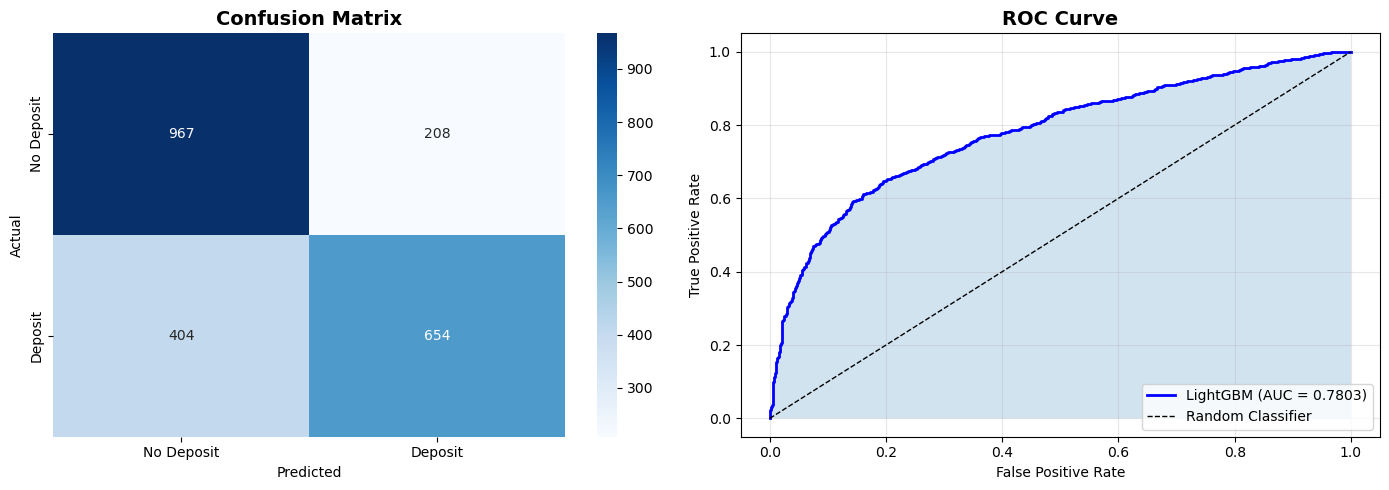


✅ Performans grafiği kaydedildi: docs/final_model_performance.png


In [22]:
# ============================================================================
# MODEL EĞİTİMİ - Optuna ile optimize edilmiş parametreler
# ============================================================================

# Optuna'dan elde edilen en iyi parametreler
best_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

print("🚀 Model eğitimi başlıyor...")
print("=" * 50)

# Model oluştur ve eğit
model = LGBMClassifier(**best_params)

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✅ Eğitim tamamlandı: {training_time:.2f} saniye")

# Tahminler
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrikler
print("\n" + "=" * 50)
print("📊 MODEL PERFORMANSI")
print("=" * 50)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Deposit', 'Deposit']))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"📈 AUC-ROC Score: {roc_auc:.4f}")

# Confusion Matrix görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Deposit', 'Deposit'],
            yticklabels=['No Deposit', 'Deposit'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'LightGBM (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/final_model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Performans grafiği kaydedildi: docs/final_model_performance.png")

## 6. Feature Importance

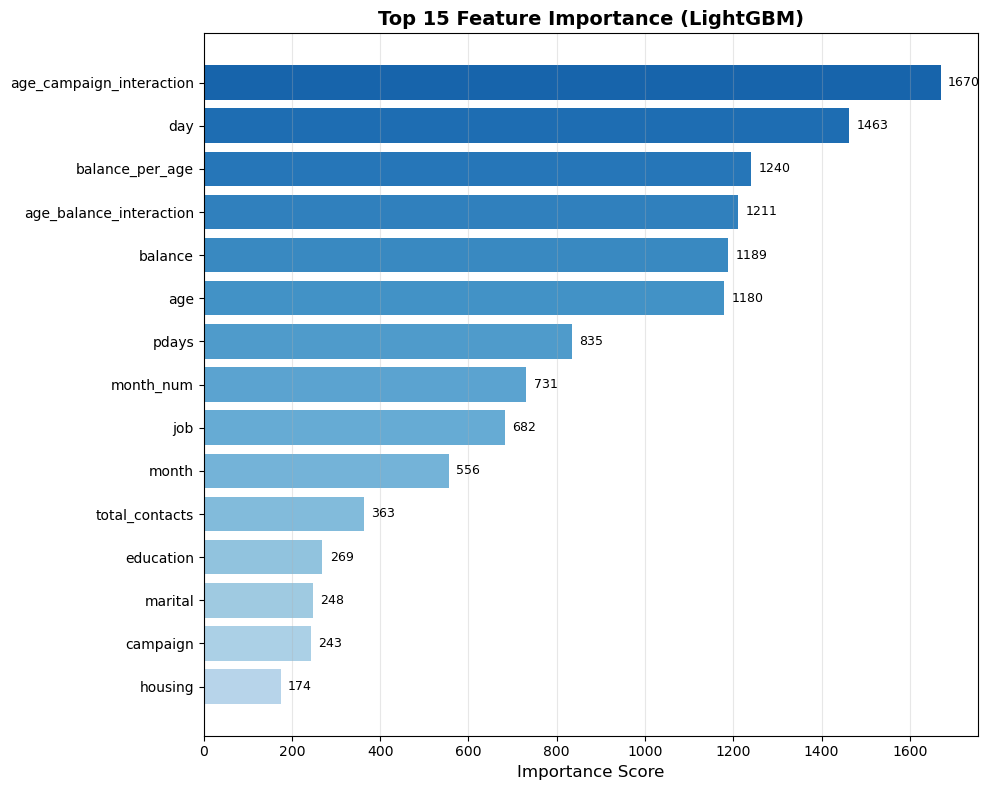

✅ Feature importance grafiği kaydedildi: docs/feature_importance_final.png

🏆 En Önemli 10 Feature:
----------------------------------------
   age_campaign_interaction : 1,670
   day                      : 1,463
   balance_per_age          : 1,240
   age_balance_interaction  : 1,211
   balance                  : 1,189
   age                      : 1,180
   pdays                    : 835
   month_num                : 731
   job                      : 682
   month                    : 556


In [23]:
# ============================================================================
# FEATURE IMPORTANCE ANALİZİ
# ============================================================================

# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = importance_df.head(top_n)

colors = plt.cm.Blues(np.linspace(0.8, 0.3, top_n))
bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Değerleri bar üzerine yaz
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values)):
    ax.text(val + max(top_features['importance']) * 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../docs/feature_importance_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Feature importance grafiği kaydedildi: docs/feature_importance_final.png")

# Top 10 feature'ı göster
print("\n🏆 En Önemli 10 Feature:")
print("-" * 40)
for i, row in importance_df.head(10).iterrows():
    print(f"   {row['feature']:25s}: {row['importance']:,.0f}")

## 7. Model Kaydetme (Artifact Export)

In [24]:
# ============================================================================
# MODEL ARTİFACT'LARINI KAYDETME
# ============================================================================

# Klasör oluştur
model_dir = Path('../models/final')
model_dir.mkdir(parents=True, exist_ok=True)

print("💾 Model artifact'ları kaydediliyor...")
print("=" * 50)

# 1. Model
model_path = model_dir / 'model.pkl'
joblib.dump(model, model_path)
print(f"✅ Model: {model_path}")

# 2. Label Encoders
encoders_path = model_dir / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label Encoders: {encoders_path}")

# 3. Feature Columns
features_path = model_dir / 'feature_columns.pkl'
joblib.dump(feature_columns, features_path)
print(f"✅ Feature Columns: {features_path}")

# 4. Metadata
metadata = {
    'model_type': 'LGBMClassifier',
    'version': '1.0.0',
    'training_date': datetime.now().isoformat(),
    'n_features': len(feature_columns),
    'n_training_samples': len(X_train),
    'best_params': best_params,
    'metrics': {
        'auc_roc': float(roc_auc),
        'accuracy': float(accuracy_score(y_test, y_pred)),
        'precision': float(precision_score(y_test, y_pred)),
        'recall': float(recall_score(y_test, y_pred)),
        'f1': float(f1_score(y_test, y_pred))
    },
    'feature_columns': feature_columns,
    'categorical_columns': list(label_encoders.keys())
}

metadata_path = model_dir / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✅ Metadata: {metadata_path}")

# Dosya boyutlarını göster
print("\n📦 Artifact Boyutları:")
print("-" * 40)
for file in model_dir.glob('*'):
    size_kb = file.stat().st_size / 1024
    print(f"   {file.name:25s}: {size_kb:,.1f} KB")

print("\n" + "=" * 50)
print("✅ Tüm artifact'lar başarıyla kaydedildi!")
print("=" * 50)

💾 Model artifact'ları kaydediliyor...
✅ Model: ../models/final/model.pkl
✅ Label Encoders: ../models/final/label_encoders.pkl
✅ Feature Columns: ../models/final/feature_columns.pkl
✅ Metadata: ../models/final/metadata.json

📦 Artifact Boyutları:
----------------------------------------
   feature_columns.pkl      : 0.3 KB
   metadata.json            : 1.2 KB
   model.pkl                : 1,449.5 KB
   label_encoders.pkl       : 3.1 KB

✅ Tüm artifact'lar başarıyla kaydedildi!


## 8. Inference Test (Production Simulation)

In [ ]:
# ============================================================================
# INFERENCE TEST - Production'ı simüle edelim
# ============================================================================

print("🧪 Inference Test - Artifact'lardan model yükleme...")
print("=" * 50)

# Artifact'ları yükle
loaded_model = joblib.load(model_dir / 'model.pkl')
loaded_encoders = joblib.load(model_dir / 'label_encoders.pkl')
loaded_features = joblib.load(model_dir / 'feature_columns.pkl')

with open(model_dir / 'metadata.json', 'r') as f:
    loaded_metadata = json.load(f)

print(f"✅ Model Version: {loaded_metadata['version']}")
print(f"✅ Training Date: {loaded_metadata['training_date'][:10]}")
print(f"✅ Features: {loaded_metadata['n_features']}")

# Test örneği oluştur
print("\n📝 Örnek Müşteri Profilleri:")
print("-" * 50)

sample_customers = [
    {
        'age': 35, 'job': 'management', 'marital': 'married', 'education': 'tertiary',
        'default': 'no', 'balance': 5000, 'housing': 'yes', 'loan': 'no',
        'contact': 'cellular', 'day': 15, 'month': 'may', 'duration': 300,
        'campaign': 2, 'pdays': 10, 'previous': 1, 'poutcome': 'success'
    },
    {
        'age': 55, 'job': 'retired', 'marital': 'single', 'education': 'secondary',
        'default': 'no', 'balance': 15000, 'housing': 'no', 'loan': 'no',
        'contact': 'cellular', 'day': 10, 'month': 'jun', 'duration': 450,
        'campaign': 1, 'pdays': 5, 'previous': 2, 'poutcome': 'success'
    },
    {
        'age': 25, 'job': 'student', 'marital': 'single', 'education': 'tertiary',
        'default': 'no', 'balance': 500, 'housing': 'no', 'loan': 'yes',
        'contact': 'telephone', 'day': 20, 'month': 'nov', 'duration': 100,
        'campaign': 5, 'pdays': -1, 'previous': 0, 'poutcome': 'unknown'
    }
]

# Her örnek için tahmin yap
for i, customer in enumerate(sample_customers, 1):
    # DataFrame oluştur
    sample_df = pd.DataFrame([customer])
    
    # Preprocessing - tuple döndürüyor, sadece X'i al
    sample_processed, _ = preprocess_data(sample_df.copy())
    
    # Feature Engineering
    sample_fe = engineer_features(sample_processed.copy())
    
    # Encode
    sample_encoded, _ = encode_categorical(sample_fe, loaded_encoders, is_training=False)
    
    # Eksik feature'ları ekle (0 ile doldur)
    for col in loaded_features:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    # Sırala
    sample_encoded = sample_encoded[loaded_features]
    
    # Tahmin
    prob = loaded_model.predict_proba(sample_encoded)[0][1]
    pred = "✅ DEPOSIT" if prob > 0.5 else "❌ NO DEPOSIT"
    
    print(f"\n👤 Müşteri {i}: {customer['age']} yaş, {customer['job']}, balance={customer['balance']}")
    print(f"   🎯 Tahmin: {pred} (Olasılık: {prob:.1%})")

🧪 Inference Test - Artifact'lardan model yükleme...
✅ Model Version: 1.0.0
✅ Training Date: 2025-12-02
✅ Features: 25

📝 Örnek Müşteri Profilleri:
--------------------------------------------------
⚠️ 'duration' sütunu çıkarıldı (production'da bilinmez)


AttributeError: 'tuple' object has no attribute 'copy'

## 9. Final Özet ve Sonraki Adımlar

In [ ]:
# ============================================================================
# FINAL ÖZET
# ============================================================================

print("=" * 60)
print("🎉 BANK MARKETING ML PİPELINE - TAMAMLANDI!")
print("=" * 60)

print("\n📊 MODEL PERFORMANS ÖZETİ:")
print("-" * 40)
print(f"   📈 AUC-ROC: {metadata['metrics']['auc_roc']:.4f}")
print(f"   🎯 Accuracy: {metadata['metrics']['accuracy']:.4f}")
print(f"   ✓ Precision: {metadata['metrics']['precision']:.4f}")
print(f"   ◎ Recall: {metadata['metrics']['recall']:.4f}")
print(f"   ⚖️ F1-Score: {metadata['metrics']['f1']:.4f}")

print("\n📦 KAYITLI ARTIFACT'LAR:")
print("-" * 40)
print("   ✅ models/final/model.pkl")
print("   ✅ models/final/label_encoders.pkl")
print("   ✅ models/final/feature_columns.pkl")
print("   ✅ models/final/metadata.json")

print("\n🔧 PİPELINE BİLEŞENLERİ:")
print("-" * 40)
print(f"   📊 Feature Engineering: {len(feature_columns)} feature")
print(f"   🔢 Categorical Encoding: {len(label_encoders)} sütun")
print(f"   🤖 Model: LightGBM (Optuna-optimized)")
print(f"   ⏱️ Training Time: {training_time:.2f} saniye")

print("\n🚀 SONRAKİ ADIMLAR:")
print("-" * 40)
print("   1. src/app.py ile FastAPI+Gradio server'ını başlat")
print("   2. Render veya Hugging Face'e deploy et")
print("   3. docs/ klasöründeki notları gerçek metriklerle güncelle")

print("\n" + "=" * 60)
print("✨ Pipeline hazır! API deployment için: python src/app.py")
print("=" * 60)